### Imports

In [2]:
# Data Management
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Unsupervised Learning
from sklearn.decomposition import PCA

# Deep Learning
import torch
from torch.utils.data import Dataset,DataLoader

# Visualization
import matplotlib.pyplot as plt

### Data Extraction

In [6]:
df = pd.read_csv('../1_Unsupervised/data/etf_pairs.csv')
df.drop(columns=['Date'],inplace=True)
df

,asset_1,asset_2,spread,z_score
0,50.461056,42.633717,-6.816010,-2.005521
1,50.401669,42.593018,-6.820720,-1.966081
2,49.999657,42.503490,-7.102455,-2.102464
3,49.967682,42.487202,-7.112546,-2.051592
4,50.931583,42.804634,-6.575105,-1.671952
...,...,...,...,...
1656,81.379997,57.259998,4.452979,2.132583
1657,82.400002,57.540001,5.096808,2.412733
1658,82.699997,57.889999,4.926592,2.285733
1659,82.370003,57.919998,4.556295,2.069805


In [8]:
# Feature Engineering

df['log_return_1'] = np.log(df['asset_1'] / df['asset_1'].shift(1))
df['log_return_2'] = np.log(df['asset_2'] / df['asset_2'].shift(1))

df['rolling_log_return_1'] = df['log_return_1'].rolling(21).mean()
df['rolling_log_return_2'] = df['log_return_2'].rolling(21).mean()

df['prod_return_1'] = df['log_return_1'].cumsum()
df['prod_return_2'] = df['log_return_2'].cumsum()

df.dropna(inplace=True)
df.tail(3)

,asset_1,asset_2,spread,z_score,log_return_1,log_return_2,rolling_log_return_1,rolling_log_return_2,prod_return_1,prod_return_2
1658,82.699997,57.889999,4.926592,2.285733,0.003634,0.006064,0.006647,0.002487,0.469162,0.302087
1659,82.370003,57.919998,4.556295,2.069805,-0.003998,0.000518,0.006661,0.002350,0.465163,0.302606
1660,81.099998,57.959999,3.232551,1.431051,-0.015538,0.000690,0.005670,0.002400,0.449625,0.303296


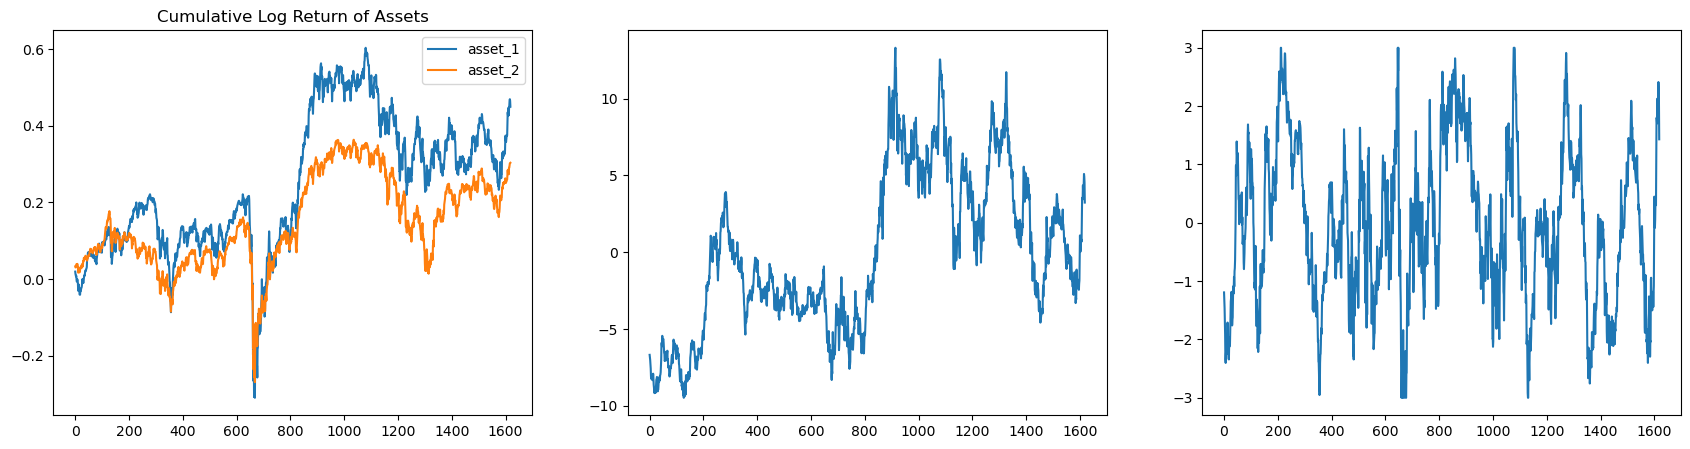

In [16]:
# Visualize the Data

fig=plt.figure(figsize=(21,5))

plt.subplot(1,3,1)
plt.plot(df['prod_return_1'].values,label='asset_1')
plt.plot(df['prod_return_2'].values,label='asset_2')
plt.legend()
plt.title('Cumulative Log Return of Assets')

plt.subplot(1,3,2)
plt.plot(df['spread'].values,label='spread')
plt.title('Spread')
plt.subplot(1,3,3)
plt.plot(df['z_score'].values,label='spread')
plt.title('Z Score')